In [1]:
# Necessary  packages
import os
import sys
import time
import numpy
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split

In [2]:
#REPOSITORY PATH OF PROJECT
PATH_DEV_CLEAN = os.getcwd()
(PATH_DEV,_) = os.path.split(os.getcwd())
PATH_PROJECT,y = os.path.split(PATH_DEV)
PATH_DATA = os.path.join(PATH_PROJECT,'Data')
PATH_DATA_CBIRH = os.path.join(PATH_DATA,'DATA_CBIRH_1')
PATH_DATA_CSV = os.path.join(PATH_DATA,'Data_csv\All descriptors')
LIST_CLASS = os.listdir(PATH_DATA_CBIRH)
print(os.listdir(PATH_DATA_CSV))

['DF_ALL.csv', 'DF_ALL_0.csv', 'Model_RF.joblib', 'RandomForeastModel.joblib', 'RandomForeastModel_0.joblib', 'Testset.joblib', 'Trainset.joblib']


In [50]:
#Read data frame
def read_data(path):
    DF = pd.read_csv(path)
    DF = DF.iloc[:,1::]
    return DF

#split data frame
def split_data(DF):
    DF = DF.iloc[:,1::]
    y =  y=DF[DF.columns[-1]] 
    del DF[DF.columns[-1]]
    X = DF
    return X,y

#plot confusion matrix
def plot_confusion_catrix(cm):
    
    sb.set(rc={'figure.figsize':(8,8)})
    sb.set(font_scale=1.4)#for label size
    ax = sb.heatmap(cm, annot=True, cmap ='Oranges', cbar=False)
    ax.set_title('Confusion Matrix with labels\n')
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('\nTrue Label ')
    _= ax.xaxis.set_ticklabels(['CAR','DOG','FRUIT','PERSON','CAT'])
    _= ax.yaxis.set_ticklabels(['CAR','DOG','FRUIT','PERSON','CAT'])
    
#evaluate of result
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    errors = 1-accuracy
    Confusion_Matrix = confusion_matrix(test_labels, predictions)
    print('Model Performance')
    print('Average Error: {:0.2f} %.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Classification_report :\n',classification_report(test_labels,predictions))
    print('Confusion_Matrix : \n')
    plot_confusion_catrix(Confusion_Matrix)

# feature selection
def select_features(X_train, y_train, X_test, max_depth, max_features):
    # configure to select a subset of features
    # learn relationship from training data
    fs = SelectFromModel(RandomForestClassifier(n_estimators=200,criterion ='entropy', max_depth=max_depth),
                         max_features=max_features)    
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    # transform test input data
    return X_train_fs, X_test_fs, fs

#tuning hyperparameter of model   
def hyperparameter_tuning_randomforestClassifier(xtrain,ytrain,xtest,ytest):
    start = time.time()
    rfc=RandomForestClassifier(bootstrap = False)   
    param_grid = {  'n_estimators': list(np.arange(100, 500, 100)),
                'criterion' :['gini', 'entropy'],
                'max_depth' : np.arange(3, 10, 2),
                'min_samples_split' : np.arange(2, 10, 2),
                'max_features': ['auto', 'sqrt', 'log2', None],
                'bootstrap': [False]
             }
    kf = KFold(n_splits=5, random_state = 0, shuffle = True)
    randomizedsearch = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid,n_iter = 150,
                                          scoring='accuracy', cv= kf)
    randomizedsearch.fit(xtrain, ytrain)
    end = time.time()
    run_time = end - start
    print("[INFO] Applying took {:.2f} min".format(run_time/60))
    return randomizedsearch

### Work with 511 caracteristiques 

In [7]:
# Model RF + Data Frame + Data Frame Split (Train+Test) : 511 caracteristiques
clf = load(PATH_DATA_CSV+"\Model_RF.joblib")
df = read_data(PATH_DATA_CSV+"\DF_ALL.csv")
Trainset = load(PATH_DATA_CSV+"\Trainset.joblib") 
Testset = load(PATH_DATA_CSV+"\Testset.joblib") 

In [10]:
# Split Dataframe
Xtrain,ytrain = split_data(Trainset)
Xtest, ytest = split_data(Testset)
X,y = split_data(df)

In [33]:
#Train model
clf.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=False, max_depth=7, max_features='log2',
                       n_estimators=700)

In [34]:
# Summarize feature importance
importance_=[]
list_index = []
importance_all=[]
importance_features_importances = clf.feature_importances_

print("[INFO] Nombre total de caractéristiques = {} ".format(len(importance_features_importances)))
for i,v in enumerate(importance_features_importances):
    if v!=0:
        importance_all.append(v)
    if v>0.004 : 
        #print('Feature: %0d, Score: %.5f' % (i,v))
        importance_.append(v)
        list_index.append(str(i))
print("[INFO] Nombre de caractéristiques selectionnées = {} ".format(len(importance_)))

[INFO] Nombre total de caractéristiques = 511 
[INFO] Nombre de caractéristiques selectionnées = 65 


In [35]:
#Filter of scores by threshold = 0.4%
feat_importances = pd.Series(importance_features_importances, index=Xtrain.columns)
columns_importances = feat_importances[lambda x: x>0.004].index
print(len(columns_importances))
# index of features with score more than 0.4%
columns_importances

65


Index(['1', '3', '4', '5', '6', '7', '9', '12', '13', '14', '17', '18', '27',
       '32', '33', '34', '36', '37', '38', '39', '42', '43', '44', '52', '53',
       '54', '56', '57', '58', '59', '63', '64', '67', '68', '69', '70', '71',
       '72', '73', '74', '77', '78', '79', '82', '83', '84', '85', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '96', '109', '110', '241',
       '242', '305', '373', '374', '425'],
      dtype='object')

In [39]:
#Methgode of reduce dimension of vectors
def reduce_dim(vect):
    columns_importances = ['1', '3', '4', '5', '6', '7', '9', '12', '13', '14', '17', '18', '27',
       '32', '33', '34', '36', '37', '38', '39', '42', '43', '44', '52', '53',
       '54', '56', '57', '58', '59', '63', '64', '67', '68', '69', '70', '71',
       '72', '73', '74', '77', '78', '79', '82', '83', '84', '85', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '96', '109', '110', '241',
       '242', '305', '373', '374', '425']
    return [vect[int(i)] for i in columns_importances]

Model Performance
Average Error: 0.14 %.
Accuracy = 0.86%.
Classification_report :
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       0.72      0.68      0.70        19
           2       0.70      0.67      0.68        21
           3       1.00      1.00      1.00        25
           4       1.00      0.94      0.97        18

    accuracy                           0.86       100
   macro avg       0.85      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

Confusion_Matrix : 



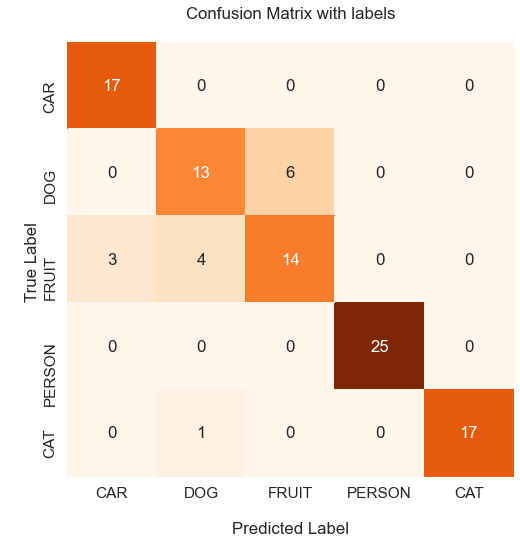

In [43]:
#evaluate best estimator with 511 caracteristiques
evaluate(clf,Xtest,ytest)

### Work with 511 caracteristiques 

In [45]:
# Selectionnement des caractéristiques importante "65"
Xtrain_fs, Xtest_fs, fs = select_features(Xtrain, ytrain, Xtest, max_depth=7, max_features=65)

In [51]:
#Chercher les meilleurs parammetres pouyr le modèle randomforest
randomizedsearch_fs = hyperparameter_tuning_randomforestClassifier(Xtrain_fs,ytrain, Xtest_fs, ytest)

[INFO] Applying took 9.98 min


In [52]:
clf_fs = randomizedsearch_fs.best_estimator_
kf = KFold(n_splits=5, random_state = 0, shuffle = True)
start = time.time()
mean_all = cross_val_score(clf_fs, Xtrain_fs, ytrain, cv=kf, scoring = 'accuracy').mean()
end = time.time()
run_time_all = (end - start)
print("[INFO] Applying took {:.2f} min".format(run_time_all/60))
print("[INFO] Accuracy {:.2f} %".format(mean_all*100))

[INFO] Applying took 0.05 min
[INFO] Accuracy 83.25 %


[INFO] Applying took 0.01 min
Model Performance
Average Error: 0.17 %.
Accuracy = 0.83%.
Classification_report :
               precision    recall  f1-score   support

           0       0.81      1.00      0.89        17
           1       0.82      0.47      0.60        19
           2       0.59      0.76      0.67        21
           3       1.00      0.96      0.98        25
           4       1.00      0.94      0.97        18

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.82       100
weighted avg       0.85      0.83      0.83       100

Confusion_Matrix : 



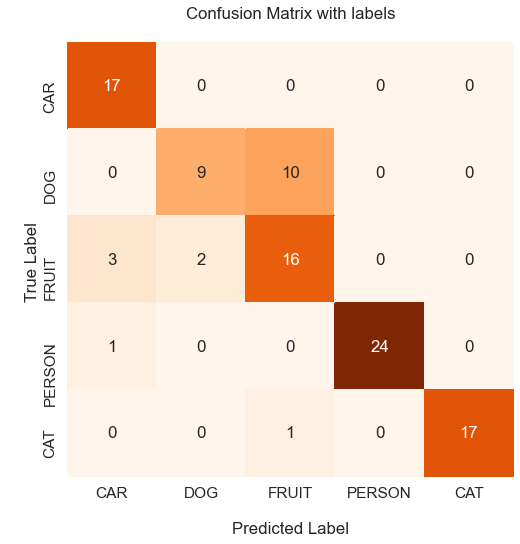

In [54]:
start = time.time()
model_fs = clf_fs.fit(Xtrain_fs,ytrain)
end = time.time()
run_time = (end - start)
print("[INFO] Applying took {:.2f} min".format(run_time/60))
evaluate(model_fs,Xtest_fs, ytest)

In [55]:
# Save the model of 65 caracteristiques
dump(model_fs,PATH_DATA_CSV+"\RandomForeast_Model_65.joblib")

['C:\\Users\\abdelkrim.saouabe\\Desktop\\Modis\\Projets\\Data Lake\\Phase_2\\Data\\Data_csv\\All descriptors\\RandomForeast_Model_65.joblib']